In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression


In [2]:
da = pd.read_excel('./final_dataset.xlsx')

با استفاده از فیچر فصل، نال های ماه مراجعه را پر می‌کنیم

In [3]:
relation_by_khanevartype = da.dropna(subset=['MahMorajeh']).groupby('Fasl')['MahMorajeh'].apply(lambda x: x.mode()[0]).to_dict()

da['MahMorajeh'] = da.apply(
    lambda row: relation_by_khanevartype[row['Fasl']] if pd.isna(row['MahMorajeh']) else row['MahMorajeh'],
    axis=1
)

In [4]:
fda = da.fillna(da.mean())
fda

,Address,MahMorajeh,Fasl,weight,khanevartype,Takmil,town,province_encoded,Urban,Year,...,value_Transport,value_Expenditure,value_invesments,value_vehicle,income_pension,income_rent,income_interest,income_aid,income_resale,income_transfer
0,20001383908,5.0,2,5.148654,1,1,1,0,False,1398,...,750000,63213552.0,1.358880e+07,5.100000e+06,1.013905e+08,1.106307e+07,8.321593e+06,3.292025e+07,1.611713e+06,9.194932e+06
1,20001383908,5.0,2,5.148654,1,1,1,0,False,1398,...,750000,63213552.0,1.358880e+07,5.100000e+06,1.013905e+08,1.106307e+07,8.321593e+06,3.292025e+07,1.611713e+06,9.194932e+06
2,20001383908,5.0,2,5.148654,1,1,1,0,False,1398,...,750000,63213552.0,1.358880e+07,5.100000e+06,1.013905e+08,1.106307e+07,8.321593e+06,3.292025e+07,1.611713e+06,9.194932e+06
3,20001383908,5.0,2,5.148654,1,1,1,0,False,1398,...,750000,63213552.0,1.358880e+07,5.100000e+06,1.013905e+08,1.106307e+07,8.321593e+06,3.292025e+07,1.611713e+06,9.194932e+06
4,20001383911,5.0,2,5.148654,1,2,1,0,False,1398,...,370000,38560000.0,1.358880e+07,5.009111e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e+07,0.000000e+00,1.000000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455785,13006383838,5.0,2,7.675848,1,2,6,30,True,1401,...,5600000,507572000.0,1.358880e+07,5.009111e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.837000e+07,0.000000e+00,0.000000e+00
455786,13006383838,5.0,2,7.675848,1,2,6,30,True,1401,...,5600000,507572000.0,1.358880e+07,5.009111e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.837000e+07,0.000000e+00,0.000000e+00
455787,13006383841,5.0,2,7.675848,1,1,6,30,True,1401,...,3100000,26700000.0,1.358880e+07,5.009111e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.837000e+07,0.000000e+00,0.000000e+00
455788,13006383841,5.0,2,7.675848,1,1,6,30,True,1401,...,3100000,26700000.0,1.358880e+07,5.009111e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.837000e+07,0.000000e+00,0.000000e+00


برای آماده سازی داده برای آموزش، داده را با توجه به آدرس(تفکیک خانوار) سال و شهری یا روستایی بودن گروه بندی می‌کنیم

In [18]:
gfda = fda.groupby(['Address', 'Year', 'Urban']).agg({i: 'mean' for i in fda.drop(columns=['Address', 'Year', 'Urban']).columns}).reset_index()

In [84]:
X = gfda.drop(columns=['value_Transport', 'Address'])
y = gfda.value_Transport

<Axes: xlabel='Year'>

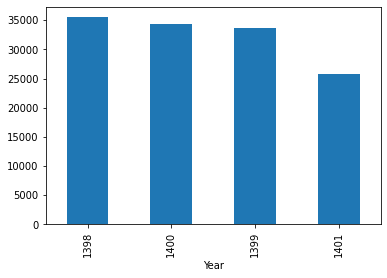

In [86]:
# تعداد برای هر سال
X.Year.value_counts().plot(kind='bar')

برای انکه مطمئن باشیم داده ها برای سال خاصی چولگی ندارند این پلات رسم شده

In [95]:
# تقریبا پخش نرماله و از هر سال به تعداد منطقی شهری و روستایی داریم
X.groupby('Year').agg({'Urban': 'value_counts'})

Urban
Year Urban       
1398 True   18712
     False  16781
1399 True   17675
     False  15915
1400 True   18133
     False  16163
1401 True   13662
     False  12096

### Validation Data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)

In [23]:
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [24]:
X_train.shape

(103309, 30)

In [41]:
[*gfda.columns]

['Address',
 'Year',
 'Urban',
 'MahMorajeh',
 'Fasl',
 'weight',
 'khanevartype',
 'Takmil',
 'town',
 'province_encoded',
 'member_x',
 'age',
 'relation_encoded',
 'gender_encoded',
 'studying_encoded',
 'degree_encoded',
 'occupationalst_encoded_x',
 'maritalst_encoded',
 'member_y',
 'occupationalst_encoded_y',
 'room',
 'space',
 'construction',
 'vehicle',
 'refridgerator',
 'fridge',
 'sewingmachine',
 'fan',
 'telephone',
 'evapcooling',
 'tenure_encoded',
 'Material_encoded',
 'HeatingFuel_encoded',
 'waterheatingfuel_encoded',
 'value_Transport',
 'value_Expenditure',
 'value_invesments',
 'value_vehicle',
 'income_pension',
 'income_rent',
 'income_interest',
 'income_aid',
 'income_resale',
 'income_transfer']

In [56]:
#gfda[['Fasl', 'Urban', 'Year', 'member_y', 'age', 'vehicle', ]]

In [37]:
rfr = GradientBoostingRegressor(n_estimators=500)
rfr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=500)

In [55]:
r2_score(y_test, rfr.predict(X_test))

0.17227186493908353

همانطور که مشاهده میشود به علت زید بودن فیچرهای انتخابی(با وجود فیچرسلکشن) مدل از نتیجه خوبی برخوردار نیست
پس از مدل پیچیده تری استفاده می‌کنیم

In [ ]:
models = {
    'RandomForestRegressor': (
        RandomForestRegressor(),
        {
            'max_depth': [None],
            'min_samples_split': [2, 5, 10],
        },
    ),
    'DecisionTreeRegressor': (
        DecisionTreeRegressor(),
        {
            'max_depth': [3, 5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
        },
    ),
    'CatBoostRegressor': (
        CatBoostRegressor(),
        {
            'learning_rate': [0.01, 0.03, 0.1, 1],
            'depth': [4, 6, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9]
        }
    ),
    'GradientBoostingRegressor': (
        GradientBoostingRegressor(),
        {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5, 10, 20],
            'alpha': [0.5, 0.9]
        },
    ),
}

In [68]:
param = {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5, 10, 20],
            'alpha': [0.5, 0.9]
        }
grid = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.5, 0.9], 'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [100, 200, 500]},
             scoring='r2', verbose=1)

In [ ]:
best_model = grid.best_estimator_
grid.best_score_

#### نتیجه روی داده تست

In [ ]:
test = pd.read_excel('./TestData.xlsx')
X_test = test.drop(columns=['Address', 'value_Transport'])
y_test = test.value_Transport
r2_score(y_test, best_model.predict(X_test))

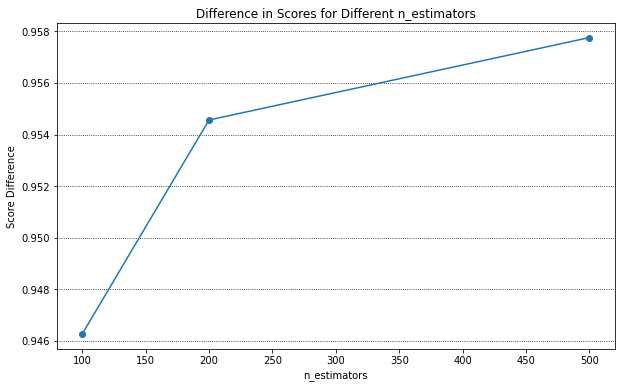

In [82]:
cv_results = grid.cv_results_

n_estimators = cv_results['param_n_estimators'].data
mean_test_scores = cv_results['mean_test_score']
d = {i: -1 for i in n_estimators}
for i, j in zip(n_estimators, mean_test_scores):
    d[i] = max(d[i], j)

plt.figure(figsize=(10,6))
plt.plot(d.keys(), d.values(), marker='o')
plt.title('Difference in Scores for Different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Score Difference')
plt.grid(axis='y', ls=':', color='k')
plt.show()

همانطور که مشاهده میشود با افزایش تعداد estimator ها عملکرد بهبود میابد
مهم ترین بهبود نیز از افزایش تعداد ۱۰۰ به ۲۰۰ رخ میدهد